In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters, feature, util
import cv2

In [15]:
def read_band_data(file_path, shape):
    with open(file_path, 'r') as file:
        data = file.read().split()
    return np.array(data, dtype=float).reshape(shape)

def downsample(array, factor):
    """簡單的降採樣函數，通過選擇每隔 factor 個像素的方式"""
    return array[::factor, ::factor]

def calculate_ndi(band03, band04):
    return np.divide(band03 - band04, band03 + band04, out=np.zeros_like(band03), where=(band03 + band04) != 0)

def save_result(result, output_file):
    with open(output_file, 'w') as file:
        for row in result:
            file.write(' '.join(map(lambda x: f"{x:.6f}", row)) + '\n')

def filter_edges_by_angle(edges, min_angle=85, max_angle=100):

    edges_unit8 = (edges * 255).astype(np.uint8)

    lines = cv2.HoughLinesP(edges_unit8, 1, np.pi/180, threshold=15, minLineLength=10, maxLineGap=10)
    mask = np.zeros_like(edges_unit8)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
            if min_angle <= angle <= max_angle or min_angle <= (180 - angle) <= max_angle:
                cv2.line(mask, (x1, y1), (x2, y2), 255, 2)
    
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    
    filtered_edges = cv2.bitwise_and(edges_unit8, mask)
    return filtered_edges

def find_contour(filtered_edges):
    contours, _ = cv2.findContours(filtered_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_edges = np.zeros_like(filtered_edges)

    for contour in contours:
        length = cv2.arcLength(contour, closed=True)
        if length > 100 and length < 300:    
            cv2.drawContours(color_edges, [contour], -1, 255, 2)
            print(f"Length: {length:.2f}")
    return color_edges

def enhance_internal_waves(image, row_of_interest=60):
    image = np.clip(image, -1, 1)
    
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98), out_range=(-1, 1))
    
    horizontal_kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
    ])

    vertical_kernel = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
    ])

    horizontal_filtered = cv2.filter2D(util.img_as_ubyte(img_rescale), -1, horizontal_kernel)
    vertical_filtered = cv2.filter2D(util.img_as_ubyte(img_rescale), -1, vertical_kernel)
    
    combined_filtered = (horizontal_filtered + vertical_filtered) / 2.0
    
    img_highpass = combined_filtered - filters.gaussian(combined_filtered, sigma=10)

    # 進行 clipping，確保數據在 [-1, 1] 之間
    img_highpass_clipped = np.clip(img_highpass, -1, 1)

    edges = feature.canny(img_highpass_clipped, sigma=3)

    filtered_edges = filter_edges_by_angle(edges)
    color_edges = find_contour(filtered_edges)

    img_highpass_uint8 = util.img_as_ubyte(img_highpass_clipped)
    edges_color = cv2.cvtColor(img_highpass_uint8, cv2.COLOR_GRAY2BGR)
    edges_color[color_edges != 0] = [0, 255, 255]
    
    return combined_filtered, img_highpass_clipped, edges, edges_color


讀取通道數據

In [16]:
# 讀取數據
band03 = read_band_data(r'C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\datas\Band03txt\20190617_20190618\tbb-201906180510.ext.01.fld_output.txt', (200, 200))
band04 = read_band_data(r'C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\datas\Band04txt\20190617_20190618\tbb-201906180510.vis.03.fld_output.txt', (100, 100))

通道處理

In [17]:
band03_downsampled = downsample(band03, 2)
assert band03_downsampled.shape == band04.shape, "形狀不匹配"
ndi = calculate_ndi(band03_downsampled, band04)
ndi = np.clip(ndi, -1, 1)

combined_filtered, img_highpass, edges , edges_color  = enhance_internal_waves(ndi)

PLOT

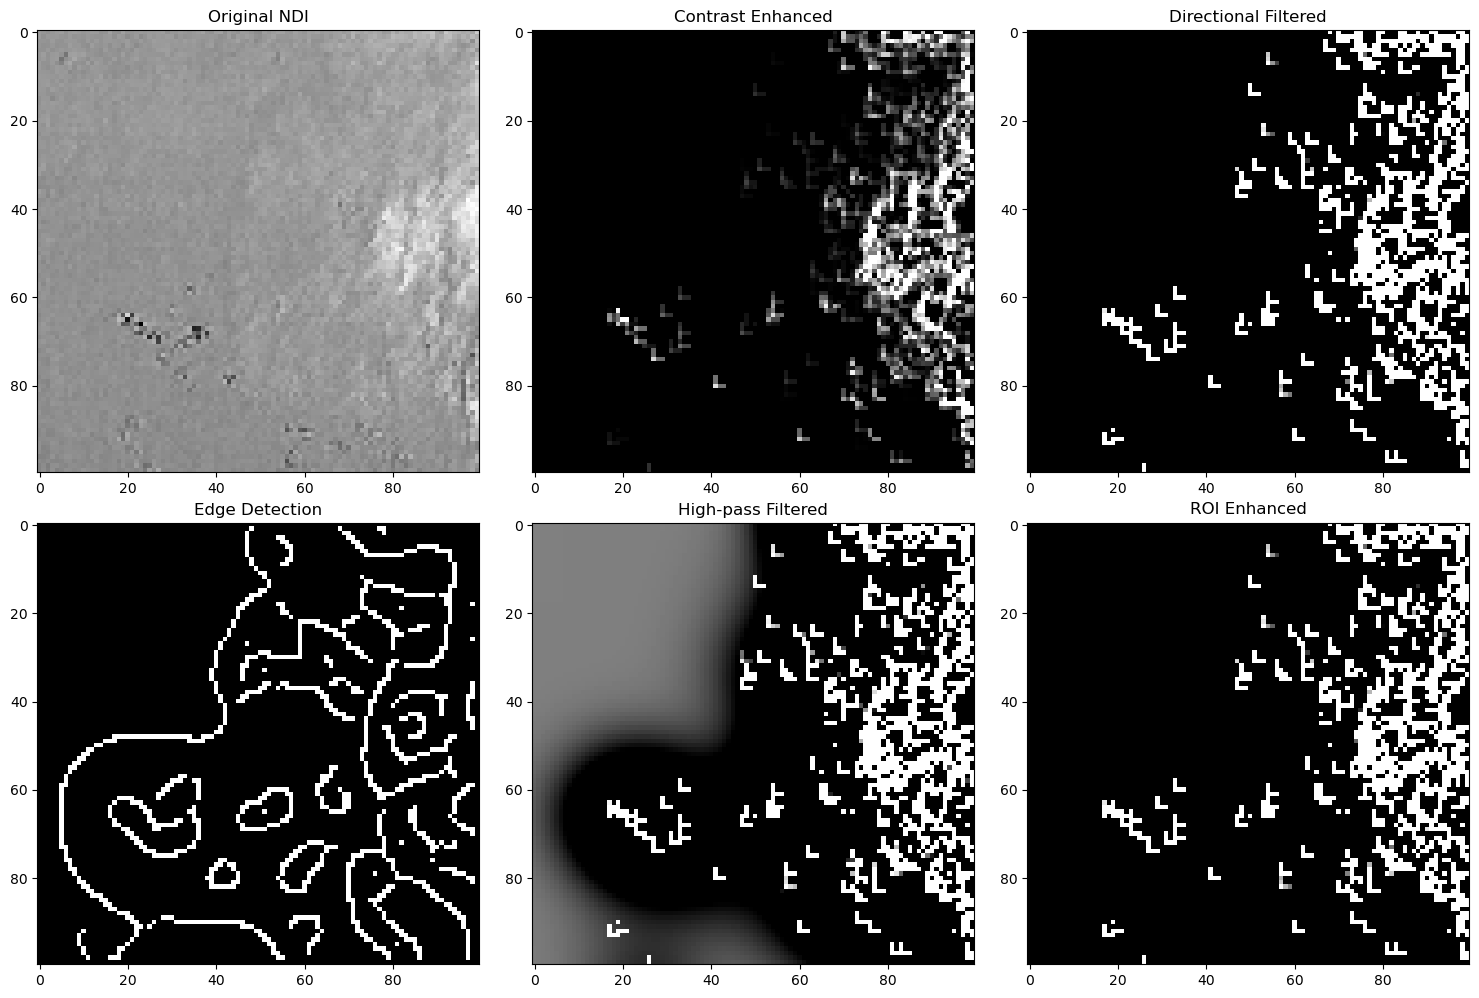

處理完成，結果已保存到 ndi_result.txt


In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(ndi, cmap='gray')
axes[0, 0].set_title('Original NDI')
axes[0, 1].imshow(combined_filtered, cmap='gray')
axes[0, 1].set_title('Contrast Enhanced')
axes[0, 2].imshow(edges_color, cmap='gray')
axes[0, 2].set_title('Directional Filtered')
axes[1, 0].imshow(edges, cmap='gray')
axes[1, 0].set_title('Edge Detection')
axes[1, 1].imshow(img_highpass, cmap='gray')
axes[1, 1].set_title('High-pass Filtered')
axes[1, 2].imshow(edges_color, cmap='gray')
axes[1, 2].set_title('ROI Enhanced')

plt.tight_layout()
plt.show()

# 保存結果
save_result(ndi, 'ndi_result.txt')
print("處理完成，結果已保存到 ndi_result.txt")